# Study of the stability of several G&CNETs at the same time

In this notebook we define a dictionary with the filenames of several trained deep networks and we perform the stability analysis on all of them



| Packages needed    | 
|----------|
| scipy  | 
| numpy  | 
| matplotlib  | 
| pyaudi  |
| pygmo  |
| progressbar  |
| control  |


Can all be installed via pip  or conda package managers (tested in python 3.7)

In [1]:
%matplotlib inline

import pygmo as pg
from pyquad import Controller, rkf45, rkf45_gduals
import numpy as np
from math import sin, cos, sqrt, tanh
import progressbar

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

g0 = 9.81 # m/s2
m = 0.38905 # kg
T_max = 9.1 # N
theta_max = 35 # rad/sec



### 1 - Find the exact equilibrium point
We shift the reference system so that all neural controllers (GECNETs) will have the origin as equilibrum point. This corresponds to the quad hovering. We thus need to find such equilibrium point for all GECNETs 


In [2]:
# This pygmo problem is solved by the equilibrium point of the system
class my_prob:
    def __init__(self, path):
        self.Controller = Controller(path)
    def fitness(self, x):
        return [np.linalg.norm(self.Controller.compute_control(x) - np.array([g0*m, 0]))]
    def get_bounds(self):
        return ([-1,0,-1,0,0],[1,0,1,0,0])

In [3]:
# Here we create a dictionary that we will populate for each network with the stability margins
# [path, bias, error in equilibrium, controller, damp, freq, timedelay]
data = dict() 
data["N_01_0050"] = ["data/softplus/power_bebop_drag_h01_n0050_softplus.pkl", [], False, False,0.,0.,0.]
data["N_02_0050"] = ["data/softplus/power_bebop_drag_h02_n0050_softplus.pkl", [], False,False,0.,0.,0.]
data["N_03_0050"] = ["data/softplus/power_bebop_drag_h03_n0050_softplus.pkl", [], False,False,0.,0.,0.]
data["N_04_0050"] = ["data/softplus/power_bebop_drag_h04_n0050_softplus.pkl", [], False,False,0.,0.,0.]
data["N_05_0050"] = ["data/softplus/power_bebop_drag_h05_n0050_softplus.pkl", [], False,False,0.,0.,0.]
data["N_06_0050"] = ["data/softplus/power_bebop_drag_h06_n0050_softplus.pkl", [], False,False,0.,0.,0.]
data["N_07_0050"] = ["data/softplus/power_bebop_drag_h07_n0050_softplus.pkl", [], False,False,0.,0.,0.]
data["N_08_0050"] = ["data/softplus/power_bebop_drag_h08_n0050_softplus.pkl", [], False,False,0.,0.,0.]
data["N_09_0050"] = ["data/softplus/power_bebop_drag_h09_n0050_softplus.pkl", [], False,False,0.,0.,0.]
data["N_01_0100"] = ["data/softplus/power_bebop_drag_h01_n0100_softplus.pkl", [], False, False,0.,0.,0.]
data["N_02_0100"] = ["data/softplus/power_bebop_drag_h02_n0100_softplus.pkl", [], False,False,0.,0.,0.]
data["N_03_0100"] = ["data/softplus/power_bebop_drag_h03_n0100_softplus.pkl", [], False,False,0.,0.,0.]
data["N_04_0100"] = ["data/softplus/power_bebop_drag_h04_n0100_softplus.pkl", [], False,False,0.,0.,0.]
data["N_05_0100"] = ["data/softplus/power_bebop_drag_h05_n0100_softplus.pkl", [], False,False,0.,0.,0.]
data["N_06_0100"] = ["data/softplus/power_bebop_drag_h06_n0100_softplus.pkl", [], False,False,0.,0.,0.]
data["N_07_0100"] = ["data/softplus/power_bebop_drag_h07_n0100_softplus.pkl", [], False,False,0.,0.,0.]
data["N_08_0100"] = ["data/softplus/power_bebop_drag_h08_n0100_softplus.pkl", [], False,False,0.,0.,0.]
data["N_09_0100"] = ["data/softplus/power_bebop_drag_h09_n0100_softplus.pkl", [], False,False,0.,0.,0.]
data["N_01_0200"] = ["data/softplus/power_bebop_drag_h01_n0200_softplus.pkl", [], False, False,0.,0.,0.]
data["N_02_0200"] = ["data/softplus/power_bebop_drag_h02_n0200_softplus.pkl", [], False,False,0.,0.,0.]
data["N_03_0200"] = ["data/softplus/power_bebop_drag_h03_n0200_softplus.pkl", [], False,False,0.,0.,0.]
data["N_04_0200"] = ["data/softplus/power_bebop_drag_h04_n0200_softplus.pkl", [], False,False,0.,0.,0.]
data["N_05_0200"] = ["data/softplus/power_bebop_drag_h05_n0200_softplus.pkl", [], False,False,0.,0.,0.]
data["N_06_0200"] = ["data/softplus/power_bebop_drag_h06_n0200_softplus.pkl", [], False,False,0.,0.,0.]
data["N_07_0200"] = ["data/softplus/power_bebop_drag_h07_n0200_softplus.pkl", [], False,False,0.,0.,0.]
data["N_08_0200"] = ["data/softplus/power_bebop_drag_h08_n0200_softplus.pkl", [], False,False,0.,0.,0.]
data["N_09_0200"] = ["data/softplus/power_bebop_drag_h09_n0200_softplus.pkl", [], False,False,0.,0.,0.]

In [6]:
for N in progressbar.progressbar(data):
    udp = my_prob(data[N][0])
    prob = pg.problem(udp)
    algo = pg.algorithm(pg.de(gen=300, xtol=1e-14, ftol=1e-14))
    algo.set_verbosity(1)
    pop = pg.population(prob,19)
    pop.push_back([0,0,0,0,0])
    pop = algo.evolve(pop)
    data[N][1] = pop.champion_x
    err = np.linalg.norm(udp.Controller.compute_control(pop.champion_x) - np.array([3.81658050, 0]))
    data[N][2] = err

 92% (25 of 27) |######################  | Elapsed Time: 0:01:20 ETA:   0:00:16/usr/lib/python3.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)
100% (27 of 27) |########################| Elapsed Time: 0:01:39 Time:  0:01:39


### 2 - Redefine the Controller so that the origin is the equilibrium point

In [7]:
class UnbiasedController(Controller):
    def __init__(self, path_to_pickle, bias):
        super(UnbiasedController, self).__init__(path_to_pickle)
        self.bias = np.array(bias)
    def compute_control(self, state):
        return super(UnbiasedController, self).compute_control(state + self.bias)

In [8]:
for N in progressbar.progressbar(data):
    data[N][3] = UnbiasedController(data[N][0], data[N][1])


100% (27 of 27) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [9]:
for N in progressbar.progressbar(data):
    a = data[N][3].compute_control([0,0,0,0,0])
    # To check the hovering equilibrium we print down the neurocontroller output at the found equilibrium
    print(N, "->", "u1 = ", a[0] / m, ", u2 = ", a[1])

100% (27 of 27) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


N_01_0050 -> u1 =  9.81 , u2 =  -6.459676543668635e-16
N_02_0050 -> u1 =  9.809999999999945 , u2 =  4.2377126113768426e-14
N_03_0050 -> u1 =  9.810000000000027 , u2 =  -3.73900129607696e-14
N_04_0050 -> u1 =  9.809999999999919 , u2 =  -7.855261580091977e-15
N_05_0050 -> u1 =  9.810000000000008 , u2 =  -6.4598933841031325e-15
N_06_0050 -> u1 =  9.809999999995652 , u2 =  9.098169266585909e-14
N_07_0050 -> u1 =  9.809999999999981 , u2 =  2.609674629172609e-15
N_08_0050 -> u1 =  9.809999999999953 , u2 =  -3.669156992125444e-15
N_09_0050 -> u1 =  9.809999999999999 , u2 =  5.633080807365687e-15
N_01_0100 -> u1 =  9.81 , u2 =  5.167307554065914e-16
N_02_0100 -> u1 =  9.810000000000008 , u2 =  -2.6459954019508736e-14
N_03_0100 -> u1 =  9.809999999999963 , u2 =  -5.6459828132182643e-14
N_04_0100 -> u1 =  9.810000000000006 , u2 =  -2.506458582351989e-15
N_05_0100 -> u1 =  9.809999999999977 , u2 =  2.377221683391717e-15
N_06_0100 -> u1 =  9.809999999999992 , u2 =  -8.786374405822528e-16
N_07_0100

### 3 - Simulate the dynamics

In [10]:
# This is a simple Runga Kutta fourth order numerical integrator with fixed step.
# It is programmed to work both with floats and gduals. It infers the type from the initial conditions.
# For creating plots and movies is ok, to do the Taylor map computations the rk45 (adaptive step) should be used.
def rk4(f, t0, y0, tf, N):
    h = (tf - t0) / N
    t = np.arange(t0,tf,h)
    y = np.array([[y0[0]] * np.size(y0)] * N)
    y[0] = y0
    for n in progressbar.progressbar(range(N - 1)):
        xi1 = y[n]
        f1 = f(t[n], xi1)
        xi2 = y[n] + (h/2.)*f1
        f2 = f(t[n+1], xi2)
        xi3 = y[n] + (h/2.)*f2
        f3 = f(t[n+1], xi3)
        xi4 = y[n] + h*f3
        f4 = f(t[n+1], xi4)
        y[n+1] = y[n] + (h/6.)*(f1 + 2*f2 + 2*f3 + f4)
    return y


    

In [11]:
# Our quad dynamics
def rhs(t, x, uc):
    u = uc.compute_control(x)
    return np.array([
        x[1],
         -0.5*x[1] + (u[0])/m * sin(x[4]),
        x[3],
        -0.5 *x[3] - g0 + (u[0])/m * cos(x[4]),
         u[1],
    ])

#### Trajectory plot (comparing two networks)

In [12]:
# Initial condition for the plots (x,vx,z,vz,theta)
IC = np.array([ 4. ,2., 7.,1.,1.4])
# Which one?
key1 = "N_01_0050"
key2 = "N_05_0200"

tf = 5
N = 100

res1 = rk4(lambda t,x: rhs(t,x,data[key1][3]), 0, IC, tf, N)
res2 = rk4(lambda t,x: rhs(t,x,data[key2][3]), 0, IC, tf, N)


x1 = res1[:,0]
vx1 = res1[:,1]
z1 = res1[:,2]
vz1 = res1[:,3]
theta1 = res1[:,4]
x2 = res2[:,0]
vx2 = res2[:,1]
z2 = res2[:,2]
vz2 = res2[:,3]
theta2 = res2[:,4]
t = np.arange(0, tf, tf/ N)

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


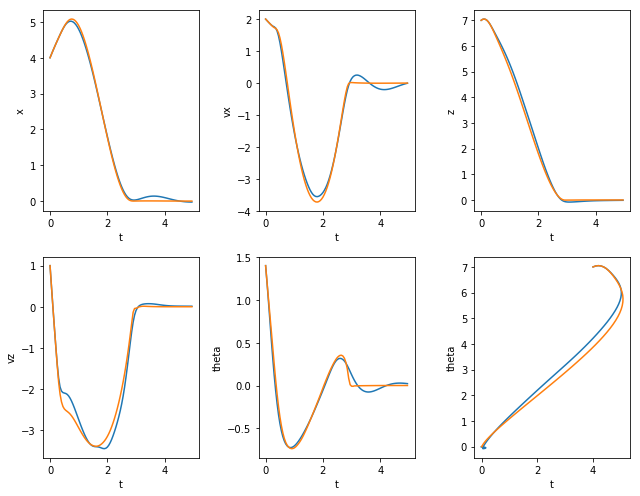

In [13]:
# And we plot (statically) the resulting trajectories
plt.figure(figsize=(9,7))
plt.subplot(231)
plt.plot(t, x1)
plt.plot(t, x2)
plt.xlabel("t")
plt.ylabel("x")
plt.subplot(232)
plt.plot(t, vx1)
plt.plot(t, vx2)
plt.xlabel("t")
plt.ylabel("vx")
plt.subplot(233)
plt.plot(t, z1)
plt.plot(t, z2)
plt.xlabel("t")
plt.ylabel("z")
plt.subplot(234)
plt.plot(t, vz1)
plt.plot(t, vz2)
plt.xlabel("t")
plt.ylabel("vz")
plt.subplot(235)
plt.xlabel("t")
plt.ylabel("theta")
plt.plot(t, theta1)
plt.plot(t, theta2)
plt.subplot(236)
plt.xlabel("t")
plt.ylabel("theta")
plt.plot(x1, z1)
plt.plot(x2, z2)
plt.tight_layout()

(-8, 8)

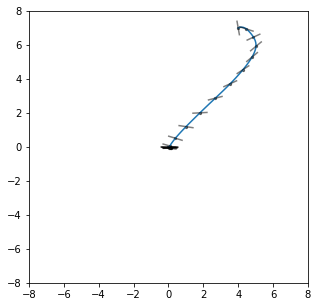

In [14]:
def plot_quad_traj(x,z,theta, L, ax):
    # Quad Terminal points
    x1 = x + L * np.cos(theta)
    z1 = z - L * np.sin(theta)
    x2 = x - L * np.cos(theta) 
    z2 = z + L * np.sin(theta) 

    ax.plot(x,z)
    for i in range(len(x1))[::5]:
        ax.plot([x1[i],x2[i]], [z1[i],z2[i]],"k", alpha=0.5)
        ax.scatter(x[i],z[i], s=5,color='k', alpha=0.5)
        
L=0.4
fig = plt.figure(figsize=(5,5))
plot_quad_traj(x1,z1,theta1, L,fig.gca())
plt.xlim((-8, 8))
plt.ylim((-8, 8))


#### Plots for different initial conditions IC

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


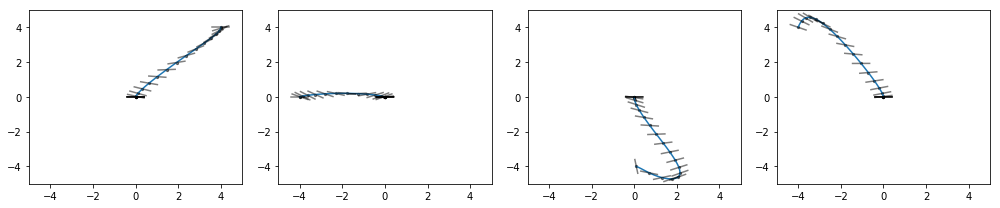

In [25]:
IC = []
IC.append(np.array([ 4. ,0, 4.,0,0]))
IC.append(np.array([ -4. ,0, 0,0,0]))
IC.append(np.array([ 0.1 ,4., -4.,-2.,1.4]))
IC.append(np.array([ -4. ,1., 4.,3.,0.4]))
#IC.append(np.array([ 4. ,1., 4.,1.,-0.4]))
#IC.append(np.array([ -4. ,1., 4.,1.,0.4]))
L=0.4
tf = 3.
N = 100

fig = plt.figure(figsize=(14,3))
for i,x0 in enumerate(IC):
    ax = plt.subplot(1,4,i+1)
    res = rk4(lambda t,x: rhs(t,x,data[key2][3]), 0, x0, tf, N)
    plot_quad_traj(res[:,0],res[:,2],res[:,4], L,ax)
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
plt.tight_layout()
plt.savefig("media/trajs.png")


### 4 - Analyze the System Stability (linear)

The system linear stabilty around the equilibrium point (origin) is studied. 

Write the overall system as:

$$
\dot {\mathbf x} = \mathbf f(\mathbf x)
$$

introduce the variable $\mathbf x = \mathbf x_e + \delta \mathbf x$. Then:

$$
\dot {\delta \mathbf x} = \nabla \mathbf f \cdot \delta \mathbf x
$$

The resulting linear system has an analytical solution readily found by:

$$
\delta \mathbf x = e^{\mathbf A t} \delta \mathbf x_0
$$

Using the eigen decomposition of the matrix $\mathbf A$ we may write $\mathbf A\mathbf V = \mathbf V\mathbf \Lambda$. Where we have introduced the right eigenvector matrix $\mathbf V = [\mathbf v_1, \mathbf v_2, ...]$ and the eigenvalue matrix $\mathbf \Lambda$. 

Eventually the system dynamics is thus expressed as:

$$
\delta \mathbf x = \mathbf V^{-1} e^{\mathbf \Lambda t} \mathbf V 
$$

and will thus be some linear combination of terms in the form $e^{-\lambda_i t}$. The real part of the eigenvalues is then determining the asymptotic behavior of the system (needs to be negative to give asymptotic stability and its magnitude regulates the system damping time), while the imaginary part $\omega_i$ determines the oscillating behaviour introducing a frequency $f = \frac {\omega}{2\pi}$.

In [16]:
from pyaudi import gdual_double as gdual
from pyaudi import sin, cos, sqrt, tanh

# Equilibrium point
x_e = [gdual(0., name, 1) for name in ["x","vx","z","vz","th"]]

In [17]:
for N in progressbar.progressbar(data):
    # We compute the gradient of the rhs
    lin_dyn = rhs(0, x_e, data[N][3])
    ss = ["dx", "dvx", "dz", "dvz", "dth"]
    _ = [a.extend_symbol_set(ss) for a in lin_dyn]
    A = np.eye(5)
    for i in range(5):
        for  j in range(5):
            A[i,j] = lin_dyn[i].get_derivative({ss[j] : 1})
            lambdas, eigv = np.linalg.eig(A)
    decay = []
    freq = []
    for i, lam in enumerate(lambdas):
        alpha = lam.real
        beta = lam.imag
        print("Mode ", i+1, ": ", end='', flush=True)
        if alpha < 0:
            print("STABLE!", end = '', flush=True)
            if beta!=0:
                print(" - complex", end='')
                print("\n\t decay time (10%): ", np.log(0.1)/alpha, "s")
                print("\t period: ", 2*np.pi/beta, "s", flush=True)
                decay.append(np.log(0.1)/alpha)
                freq.append(2*np.pi/beta)
            else:
                print(" - real", end='')
                print("\n\t decay time (10%): ", np.log(0.1)/alpha, "s", flush=True)
                decay.append(np.log(0.1)/alpha)
                freq.append(0)
        else:
            print("UNSTABLE!", flush=True)
    data[N][4] = max(decay)
    data[N][5] = max(freq)


N/A% (0 of 27) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Mode  1 : STABLE! - real
	 decay time (10%):  0.21671471091865002 s
Mode  2 : STABLE! - complex
	 decay time (10%):  1.9440495629128722 s
	 period:  2.409671480181647 s
Mode  3 : STABLE! - complex
	 decay time (10%):  1.9440495629128722 s
	 period:  -2.409671480181647 s
Mode  4 : STABLE! - real
	 decay time (10%):  1.0679848222334882 s
Mode  5 : STABLE! - real
	 decay time (10%):  2.272721113022433 s
Mode  1 : STABLE! - real
	 decay time (10%):  0.05249010279533147 s
Mode  2 : STABLE! - real
	 decay time (10%):  0.08521150207769619 s
Mode  3 : STABLE! - real
	 decay time (10%):  0.6932690683979219 s
Mode  4 : STABLE! - real
	 decay time (10%):  1.661833292666766 s
Mode  5 : STABLE! - real
	 decay time (10%):  1.239655515770746 s


  7% (2 of 27) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:01

Mode  1 : STABLE! - real
	 decay time (10%):  0.05109659761947099 s
Mode  2 : STABLE! - real
	 decay time (10%):  0.03480293826555388 s
Mode  3 : STABLE! - complex
	 decay time (10%):  1.3794325541361445 s
	 period:  2.634563265334635 s
Mode  4 : STABLE! - complex
	 decay time (10%):  1.3794325541361445 s
	 period:  -2.634563265334635 s
Mode  5 : STABLE! - real
	 decay time (10%):  1.729419527544772 s


 11% (3 of 27) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01

Mode  1 : STABLE! - real
	 decay time (10%):  0.042627482844971275 s
Mode  2 : STABLE! - real
	 decay time (10%):  0.05636826770432253 s
Mode  3 : STABLE! - complex
	 decay time (10%):  1.1859649065087463 s
	 period:  2.522078774909339 s
Mode  4 : STABLE! - complex
	 decay time (10%):  1.1859649065087463 s
	 period:  -2.522078774909339 s
Mode  5 : STABLE! - real
	 decay time (10%):  1.2643913597741288 s


 14% (4 of 27) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:01

Mode  1 : STABLE! - real
	 decay time (10%):  0.0628872962852525 s
Mode  2 : STABLE! - complex
	 decay time (10%):  1.1943272976219321 s
	 period:  3.1169950952341257 s
Mode  3 : STABLE! - complex
	 decay time (10%):  1.1943272976219321 s
	 period:  -3.1169950952341257 s
Mode  4 : STABLE! - complex
	 decay time (10%):  0.5220766237937867 s
	 period:  3.3213138580662616 s
Mode  5 : STABLE! - complex
	 decay time (10%):  0.5220766237937867 s
	 period:  -3.3213138580662616 s


 18% (5 of 27) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01

Mode  1 : STABLE! - real
	 decay time (10%):  0.0698300958447085 s
Mode  2 : STABLE! - complex
	 decay time (10%):  0.8859939500999363 s
	 period:  2.067751109566369 s
Mode  3 : STABLE! - complex
	 decay time (10%):  0.8859939500999363 s
	 period:  -2.067751109566369 s
Mode  4 : STABLE! - real
	 decay time (10%):  0.39436671950363544 s
Mode  5 : STABLE! - real
	 decay time (10%):  0.19402442213493426 s


 22% (6 of 27) |#####                    | Elapsed Time: 0:00:00 ETA:   0:00:01

Mode  1 : STABLE! - real
	 decay time (10%):  0.14013760813914575 s
Mode  2 : STABLE! - complex
	 decay time (10%):  0.58977105517135 s
	 period:  2.0026259833748696 s
Mode  3 : STABLE! - complex
	 decay time (10%):  0.58977105517135 s
	 period:  -2.0026259833748696 s
Mode  4 : STABLE! - real
	 decay time (10%):  0.28265615155726986 s
Mode  5 : STABLE! - real
	 decay time (10%):  0.26386216117535016 s


 25% (7 of 27) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01

Mode  1 : STABLE! - real
	 decay time (10%):  0.17602216481539948 s
Mode  2 : STABLE! - complex
	 decay time (10%):  0.7058935881296133 s
	 period:  1.2285927024009062 s
Mode  3 : STABLE! - complex
	 decay time (10%):  0.7058935881296133 s
	 period:  -1.2285927024009062 s
Mode  4 : STABLE! - complex
	 decay time (10%):  0.4577484771933493 s
	 period:  8.341137296281216 s
Mode  5 : STABLE! - complex
	 decay time (10%):  0.4577484771933493 s
	 period:  -8.341137296281216 s


 29% (8 of 27) |#######                  | Elapsed Time: 0:00:00 ETA:   0:00:01

Mode  1 : STABLE! - real
	 decay time (10%):  0.25938790970590403 s
Mode  2 : STABLE! - complex
	 decay time (10%):  0.5550463777767413 s
	 period:  1.4754283176851244 s
Mode  3 : STABLE! - complex
	 decay time (10%):  0.5550463777767413 s
	 period:  -1.4754283176851244 s
Mode  4 : STABLE! - complex
	 decay time (10%):  0.781697675932486 s
	 period:  2.678618528625344 s
Mode  5 : STABLE! - complex
	 decay time (10%):  0.781697675932486 s
	 period:  -2.678618528625344 s


 33% (9 of 27) |########                 | Elapsed Time: 0:00:00 ETA:   0:00:01

Mode  1 : STABLE! - real
	 decay time (10%):  0.22771645063696455 s
Mode  2 : STABLE! - complex
	 decay time (10%):  1.7296950324462173 s
	 period:  2.481006068262211 s
Mode  3 : STABLE! - complex
	 decay time (10%):  1.7296950324462173 s
	 period:  -2.481006068262211 s
Mode  4 : STABLE! - real
	 decay time (10%):  0.9270074589985933 s
Mode  5 : STABLE! - real
	 decay time (10%):  1.968105821546167 s
Mode  1 : STABLE! - real
	 decay time (10%):  0.04393722001063996 s
Mode  2 : STABLE! - real
	 decay time (10%):  0.04877783164271212 s
Mode  3 : STABLE! - complex
	 decay time (10%):  2.086589033825535 s
	 period:  3.8002311527726413 s
Mode  4 : STABLE! - complex
	 decay time (10%):  2.086589033825535 s
	 period:  -3.8002311527726413 s
Mode  5 : STABLE! - real
	 decay time (10%):  1.690442771116816 s


 40% (11 of 27) |#########               | Elapsed Time: 0:00:01 ETA:   0:00:01

Mode  1 : STABLE! - real
	 decay time (10%):  0.044742920666753574 s
Mode  2 : STABLE! - real
	 decay time (10%):  0.03360179684536022 s
Mode  3 : STABLE! - complex
	 decay time (10%):  0.8527648923632144 s
	 period:  3.592605057745465 s
Mode  4 : STABLE! - complex
	 decay time (10%):  0.8527648923632144 s
	 period:  -3.592605057745465 s
Mode  5 : STABLE! - real
	 decay time (10%):  1.8026112464952613 s


 44% (12 of 27) |##########              | Elapsed Time: 0:00:01 ETA:   0:00:01

Mode  1 : STABLE! - real
	 decay time (10%):  0.05150319028351541 s
Mode  2 : STABLE! - real
	 decay time (10%):  0.16869667536792857 s
Mode  3 : STABLE! - real
	 decay time (10%):  2.5429863895757694 s
Mode  4 : STABLE! - real
	 decay time (10%):  1.1685420059685154 s
Mode  5 : STABLE! - real
	 decay time (10%):  1.0243891470121513 s


 48% (13 of 27) |###########             | Elapsed Time: 0:00:01 ETA:   0:00:01

Mode  1 : STABLE! - real
	 decay time (10%):  0.06215263925145467 s
Mode  2 : STABLE! - real
	 decay time (10%):  0.19271545415771474 s
Mode  3 : STABLE! - real
	 decay time (10%):  0.6224959180237549 s
Mode  4 : STABLE! - real
	 decay time (10%):  1.5192161296587856 s
Mode  5 : STABLE! - real
	 decay time (10%):  1.1888245276620524 s


 51% (14 of 27) |############            | Elapsed Time: 0:00:01 ETA:   0:00:01

Mode  1 : STABLE! - real
	 decay time (10%):  0.19500837629661644 s
Mode  2 : STABLE! - complex
	 decay time (10%):  0.5037841765825694 s
	 period:  1.1936018981643615 s
Mode  3 : STABLE! - complex
	 decay time (10%):  0.5037841765825694 s
	 period:  -1.1936018981643615 s
Mode  4 : STABLE! - real
	 decay time (10%):  1.3988429755131588 s
Mode  5 : STABLE! - real
	 decay time (10%):  0.5284989976451683 s


 55% (15 of 27) |#############           | Elapsed Time: 0:00:02 ETA:   0:00:02

Mode  1 : STABLE! - real
	 decay time (10%):  1.6963813102412095 s
Mode  2 : STABLE! - complex
	 decay time (10%):  0.3912642145362638 s
	 period:  1.060074486078142 s
Mode  3 : STABLE! - complex
	 decay time (10%):  0.3912642145362638 s
	 period:  -1.060074486078142 s
Mode  4 : STABLE! - real
	 decay time (10%):  0.20504104510057583 s
Mode  5 : STABLE! - real
	 decay time (10%):  0.32039326215356856 s


 59% (16 of 27) |##############          | Elapsed Time: 0:00:02 ETA:   0:00:02

Mode  1 : STABLE! - complex
	 decay time (10%):  0.22580734098659147 s
	 period:  0.5617841970795504 s
Mode  2 : STABLE! - complex
	 decay time (10%):  0.22580734098659147 s
	 period:  -0.5617841970795504 s
Mode  3 : UNSTABLE!
Mode  4 : STABLE! - complex
	 decay time (10%):  0.6658571034440914 s
	 period:  3.786858341492705 s
Mode  5 : STABLE! - complex
	 decay time (10%):  0.6658571034440914 s
	 period:  -3.786858341492705 s


 62% (17 of 27) |###############         | Elapsed Time: 0:00:03 ETA:   0:00:02

Mode  1 : STABLE! - complex
	 decay time (10%):  0.22301019371425762 s
	 period:  0.5184148803646046 s
Mode  2 : STABLE! - complex
	 decay time (10%):  0.22301019371425762 s
	 period:  -0.5184148803646046 s
Mode  3 : STABLE! - real
	 decay time (10%):  2.1317631559405656 s
Mode  4 : STABLE! - complex
	 decay time (10%):  0.411021474664928 s
	 period:  0.5625833911337534 s
Mode  5 : STABLE! - complex
	 decay time (10%):  0.411021474664928 s
	 period:  -0.5625833911337534 s


 66% (18 of 27) |################        | Elapsed Time: 0:00:03 ETA:   0:00:03

Mode  1 : STABLE! - real
	 decay time (10%):  0.22639560234903028 s
Mode  2 : STABLE! - complex
	 decay time (10%):  1.4695169557440189 s
	 period:  2.5603042073533584 s
Mode  3 : STABLE! - complex
	 decay time (10%):  1.4695169557440189 s
	 period:  -2.5603042073533584 s
Mode  4 : STABLE! - real
	 decay time (10%):  0.8290671375140839 s
Mode  5 : STABLE! - real
	 decay time (10%):  1.643917366311823 s


 70% (19 of 27) |################        | Elapsed Time: 0:00:03 ETA:   0:00:03

Mode  1 : STABLE! - real
	 decay time (10%):  0.03957586923997139 s
Mode  2 : STABLE! - real
	 decay time (10%):  0.04603313786844952 s
Mode  3 : STABLE! - complex
	 decay time (10%):  1.6087773165116663 s
	 period:  3.174013311641849 s
Mode  4 : STABLE! - complex
	 decay time (10%):  1.6087773165116663 s
	 period:  -3.174013311641849 s
Mode  5 : STABLE! - real
	 decay time (10%):  1.93500323512666 s


 74% (20 of 27) |#################       | Elapsed Time: 0:00:03 ETA:   0:00:02

Mode  1 : STABLE! - real
	 decay time (10%):  0.03811934797470756 s
Mode  2 : STABLE! - real
	 decay time (10%):  0.03772697188813626 s
Mode  3 : STABLE! - complex
	 decay time (10%):  1.0880388181349752 s
	 period:  3.2092305492054254 s
Mode  4 : STABLE! - complex
	 decay time (10%):  1.0880388181349752 s
	 period:  -3.2092305492054254 s
Mode  5 : STABLE! - real
	 decay time (10%):  1.3888571960654756 s


 77% (21 of 27) |##################      | Elapsed Time: 0:00:04 ETA:   0:00:02

Mode  1 : STABLE! - real
	 decay time (10%):  0.07970177720508569 s
Mode  2 : STABLE! - complex
	 decay time (10%):  2.334206598617958 s
	 period:  3.8952754986709754 s
Mode  3 : STABLE! - complex
	 decay time (10%):  2.334206598617958 s
	 period:  -3.8952754986709754 s
Mode  4 : STABLE! - complex
	 decay time (10%):  0.4470473890320613 s
	 period:  1.7083971673631766 s
Mode  5 : STABLE! - complex
	 decay time (10%):  0.4470473890320613 s
	 period:  -1.7083971673631766 s


 81% (22 of 27) |###################     | Elapsed Time: 0:00:05 ETA:   0:00:02

Mode  1 : STABLE! - real
	 decay time (10%):  0.11838296454830727 s
Mode  2 : STABLE! - real
	 decay time (10%):  0.21112010969826 s
Mode  3 : STABLE! - complex
	 decay time (10%):  1.1761037119012663 s
	 period:  4.370677129127666 s
Mode  4 : STABLE! - complex
	 decay time (10%):  1.1761037119012663 s
	 period:  -4.370677129127666 s
Mode  5 : STABLE! - real
	 decay time (10%):  0.4518137280194401 s


 85% (23 of 27) |####################    | Elapsed Time: 0:00:06 ETA:   0:00:03

Mode  1 : STABLE! - real
	 decay time (10%):  0.06598617840115302 s
Mode  2 : STABLE! - real
	 decay time (10%):  0.22571715258977018 s
Mode  3 : UNSTABLE!
Mode  4 : STABLE! - real
	 decay time (10%):  0.45217414757027524 s
Mode  5 : STABLE! - real
	 decay time (10%):  1.3754616732380451 s


 88% (24 of 27) |#####################   | Elapsed Time: 0:00:07 ETA:   0:00:02

Mode  1 : STABLE! - real
	 decay time (10%):  1.2959723307590643 s
Mode  2 : STABLE! - complex
	 decay time (10%):  0.44104189614062733 s
	 period:  1.2321394449877832 s
Mode  3 : STABLE! - complex
	 decay time (10%):  0.44104189614062733 s
	 period:  -1.2321394449877832 s
Mode  4 : STABLE! - real
	 decay time (10%):  0.126417716214031 s
Mode  5 : STABLE! - real
	 decay time (10%):  0.19880617936116188 s


 92% (25 of 27) |######################  | Elapsed Time: 0:00:08 ETA:   0:00:02

Mode  1 : STABLE! - real
	 decay time (10%):  1.3912944621852594 s
Mode  2 : STABLE! - complex
	 decay time (10%):  0.40396308844130213 s
	 period:  1.3011331444508853 s
Mode  3 : STABLE! - complex
	 decay time (10%):  0.40396308844130213 s
	 period:  -1.3011331444508853 s
Mode  4 : STABLE! - real
	 decay time (10%):  0.21964604256819553 s
Mode  5 : STABLE! - real
	 decay time (10%):  0.08086225135109637 s


 96% (26 of 27) |####################### | Elapsed Time: 0:00:10 ETA:   0:00:01

Mode  1 : STABLE! - real
	 decay time (10%):  0.044707367588756715 s
Mode  2 : STABLE! - complex
	 decay time (10%):  0.1336623231774951 s
	 period:  0.5385369161553974 s
Mode  3 : STABLE! - complex
	 decay time (10%):  0.1336623231774951 s
	 period:  -0.5385369161553974 s
Mode  4 : STABLE! - real
	 decay time (10%):  0.885465961582638 s
Mode  5 : STABLE! - real
	 decay time (10%):  0.419944849732133 s


100% (27 of 27) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


### 5 - Analyze the System Stability to time delays (linear)

The system linear stabilty around the equilibrium point (origin) is studied when a time delay $\tau$ is introduced in the control input.

We write the overall system as:

$$
\dot {\mathbf x} = \mathbf f(\mathbf x, \mathbf x^\tau)
$$

and, again considering small displacements around the stable equilibrium point at the origin, we have the representation:

$$
\dot {\delta \mathbf x} = \mathbf A \delta \mathbf x + \mathbf B \delta \mathbf x^\tau 
$$

where we have used the notation $\mathbf x = \mathbf x(t)$, $\mathbf x^\tau = \mathbf x(t-\tau)$.

This linear system with time delay has the general solution:

$$
\delta \mathbf x(t) = e^{\Phi t}\mathbf x_0
$$

where the matrix $\mathbf \Phi$ eigenvalues are obtained from the time-delayed characteristic equation:

$$
\left|\mathbf A + \mathbf Be^{-\lambda \tau} - \lambda\mathbf I\right| = 0
$$

note that for $\tau =0$ (no delay) we recover the stability study of the undelayed system.


In [18]:
# We write the dynamics as a function of both the signal and the delayed signal
def rhs_delay(t, x, xtau, uc):
    u = uc.compute_control(xtau)
    return np.array([
        x[1],
        - 0.5 * x[1] + u[0]/m * sin(x[4]),
        x[3],
        -0.5 * x[3] - g0 + u[0]/m * cos(x[4]),
         u[1],
    ])
# This must be zero if x[0] is the crossing of the imaginary axis and x[1] the time delay when it happens.
def stability_margin(x, A, B):
    # x is [imag, tau], real assumed to be zero
    lam = 1j*x[0]
    det = np.linalg.det(B*np.exp(-lam*x[1])+A-lam*np.eye(5))
    return [det.real, det.imag]

In [19]:
for N in data:
    # We compute the gradient of rhs_delay w.r.t. x and thus A (we call it Ad to retain A in the notebook)
    xtau_e = [gdual(0., name, 1) for name in ["xt","vxt","zt","vzt","tht"]]
    lin_dyn = rhs_delay(0., x_e, xtau_e, data[N][3])
    ss = ["dx", "dvx", "dz", "dvz", "dth", "dxt", "dvxt", "dzt", "dvzt", "dtht"]
    _ = [a.extend_symbol_set(ss) for a in lin_dyn]
    Ad = np.eye(5)
    for i in range(5):
        for  j in range(5):
            if lin_dyn[i].order == 0: # its a constant
                Ad[i,j] = 0
            else:
                Ad[i,j] = lin_dyn[i].get_derivative({ss[j] : 1})
    # We compute the gradient of rhs_delay w.r.t. x_tau and thus B (we call it Bu to retain B in the notebook)
    #lin_dyn = rhs_delay(0., x_e, xtau_e)
    #ss = ["dx", "dvx", "dz", "dvz", "dth", "dxt", "dvxt", "dzt", "dvzt", "dtht"]
    #_ = [a.extend_symbol_set(ss) for a in lin_dyn]
    Bu = np.eye(5)
    for i in range(5):
        for  j in range(5):
            if lin_dyn[i].order == 0: # its a constant
                Bu[i,j] = 0
            else:
                Bu[i,j] = lin_dyn[i].get_derivative({ss[j+5] : 1})
    from scipy.optimize import root
    sol = root(stability_margin, [100, 0.005], (Ad, Bu), tol=1e-10)
    print("Margin found is: ", sol.x[1], "s")
    print("Precision obtained: ", np.linalg.norm(stability_margin(sol.x, Ad, Bu)))
    data[N][6] = sol.x[1]

Margin found is:  0.20794780868224524 s
Precision obtained:  1.4620206789622657e-11
Margin found is:  0.03402207468381527 s
Precision obtained:  5.103187432895776e-09
Margin found is:  0.02329389740663501 s
Precision obtained:  6.062878446064337e-07
Margin found is:  0.026251159885135666 s
Precision obtained:  1.8065441474089428e-07
Margin found is:  0.03698958466019295 s
Precision obtained:  5.1062759411947e-08
Margin found is:  0.03857632718470523 s
Precision obtained:  9.708143359278332e-08
Margin found is:  0.05575360646392181 s
Precision obtained:  9.229510176712437e-10
Margin found is:  0.09807763482389341 s
Precision obtained:  2.43990947712551e-11
Margin found is:  0.091298091738619 s
Precision obtained:  8.278552803392481e-10
Margin found is:  0.20572815303529085 s
Precision obtained:  6.84276890805518e-13
Margin found is:  0.029307097328132827 s
Precision obtained:  1.1810075192101433e-08
Margin found is:  0.022505276283772937 s
Precision obtained:  6.005310467128298e-08
Marg

In [20]:
# Compile a table for the paper
# [path, bias, error in equilibrium, controller, damp, freq, timedelay]
for N in data:
    print("$\mathcal N^{{{}}}_{{{}}}$ & {:0.2f}s & {:0.2f}s & {:0.3f}s \\\\".format(int(N[-4:]), int(N[2:4]), data[N][4], data[N][5], data[N][6]))

$\mathcal N^{50}_{1}$ & 2.27s & 2.41s & 0.208s \\
$\mathcal N^{50}_{2}$ & 1.66s & 0.00s & 0.034s \\
$\mathcal N^{50}_{3}$ & 1.73s & 2.63s & 0.023s \\
$\mathcal N^{50}_{4}$ & 1.26s & 2.52s & 0.026s \\
$\mathcal N^{50}_{5}$ & 1.19s & 3.32s & 0.037s \\
$\mathcal N^{50}_{6}$ & 0.89s & 2.07s & 0.039s \\
$\mathcal N^{50}_{7}$ & 0.59s & 2.00s & 0.056s \\
$\mathcal N^{50}_{8}$ & 0.71s & 8.34s & 0.098s \\
$\mathcal N^{50}_{9}$ & 0.78s & 2.68s & 0.091s \\
$\mathcal N^{100}_{1}$ & 1.97s & 2.48s & 0.206s \\
$\mathcal N^{100}_{2}$ & 2.09s & 3.80s & 0.029s \\
$\mathcal N^{100}_{3}$ & 1.80s & 3.59s & 0.023s \\
$\mathcal N^{100}_{4}$ & 2.54s & 0.00s & 0.032s \\
$\mathcal N^{100}_{5}$ & 1.52s & 0.00s & 0.037s \\
$\mathcal N^{100}_{6}$ & 1.40s & 1.19s & 0.093s \\
$\mathcal N^{100}_{7}$ & 1.70s & 1.06s & 0.086s \\
$\mathcal N^{100}_{8}$ & 0.67s & 3.79s & 0.050s \\
$\mathcal N^{100}_{9}$ & 2.13s & 0.56s & 0.047s \\
$\mathcal N^{200}_{1}$ & 1.64s & 2.56s & 0.194s \\
$\mathcal N^{200}_{2}$ & 1.94s & 3.17s &

# Finding the delay with pade approximant

In [23]:
# find the maximum allowable delay
import numpy as np
import scipy.linalg as scl
import matplotlib.pyplot as plt
import control

def find_timedelay_pade(A, B, norder = 5, ntau = 100):
    tau_vec = np.linspace(0.0001, 0.15, ntau)
    del_crit = 0.
    for ik in range(0,ntau):
        # calculate the delay
        nump, denp = control.pade(tau_vec[ik], norder)
        Ap, Bp, Cp, Dp = control.ssdata(control.tf2ss(nump, denp))
        
        Ap = scl.block_diag(*((Ap,)*nstate))
        Bp = scl.block_diag(*((Bp,)*nstate))
        Cp = scl.block_diag(*((Cp,)*nstate))
        Dp = scl.block_diag(*((Dp,)*nstate))

        # interconnect the system
        Ad11 = A+np.matmul(B,Dp)
        Ad12 = np.matmul(B,Cp)
        Ad1 = np.concatenate((Ad11,Ad12), axis=1)
        Ad2 = np.concatenate((Bp,Ap), axis=1)
        Ad = np.concatenate((Ad1,Ad2), axis=0)

        eig_tmp = np.linalg.eigvals(Ad)

        if np.any(np.real(eig_tmp)>0):
            del_crit = 0.5*(tau_vec[ik] + tau_vec[ik-1])
            break

    return del_crit

# do the calculations
norder = 5
ntau = 2000
nstate = A.shape[0]
for N in data:
    # We compute the gradient of rhs_delay w.r.t. x and thus A (we call it Ad to retain A in the notebook)
    xtau_e = [gdual(0., name, 1) for name in ["xt","vxt","zt","vzt","tht"]]
    lin_dyn = rhs_delay(0., x_e, xtau_e, data[N][3])
    ss = ["dx", "dvx", "dz", "dvz", "dth", "dxt", "dvxt", "dzt", "dvzt", "dtht"]
    _ = [a.extend_symbol_set(ss) for a in lin_dyn]
    Ad = np.eye(5)
    for i in range(5):
        for  j in range(5):
            if lin_dyn[i].order == 0: # its a constant
                Ad[i,j] = 0
            else:
                Ad[i,j] = lin_dyn[i].get_derivative({ss[j] : 1})
    # We compute the gradient of rhs_delay w.r.t. x_tau and thus B (we call it Bu to retain B in the notebook)
    #lin_dyn = rhs_delay(0., x_e, xtau_e)
    #ss = ["dx", "dvx", "dz", "dvz", "dth", "dxt", "dvxt", "dzt", "dvzt", "dtht"]
    #_ = [a.extend_symbol_set(ss) for a in lin_dyn]
    Bu = np.eye(5)
    for i in range(5):
        for  j in range(5):
            if lin_dyn[i].order == 0: # its a constant
                Bu[i,j] = 0
            else:
                Bu[i,j] = lin_dyn[i].get_derivative({ss[j+5] : 1})
    tau = find_timedelay_pade(Ad, Bu, norder = norder, ntau = ntau)
    data[N][6] = tau
    print('Critical delay:', tau)
    #print(np.linalg.eig(Bu)[0])

Critical delay: 0.13728961980990495
Critical delay: 0.034031840920460237
Critical delay: 0.023308629314657332
Critical delay: 0.026233141570785393
Critical delay: 0.0369563531765883
Critical delay: 0.03860607803901951
Critical delay: 0.05577821410705353
Critical delay: 0.06867606303151577
Critical delay: 0.09132228614307154
Critical delay: 0.13961423211605806
Critical delay: 0.029307628814407204
Critical delay: 0.022483766883441725
Critical delay: 0.03193219109554778
Critical delay: 0.03703134067033517
Critical delay: 0.0911723111555778
Critical delay: 0.07092568784392198
Critical delay: 0.07504999999999999
Critical delay: 0.04730462731365684
Critical delay: 0.13444009504752374
Critical delay: 0.026458104052026015
Critical delay: 0.02375855427713857
Critical delay: 0.05015415207603803
Critical delay: 0.06042743871935969
Critical delay: 0.07504999999999999
Critical delay: 0.04977921460730366
Critical delay: 0.04190552776388195
Critical delay: 0.02398351675837919


In [20]:
# [path, bias, error in equilibrium, controller, damp, freq, timedelay]
for N in data:
    print("$\mathcal N^{{{}}}_{{{}}}$ & {:0.2f}s & {:0.2f}s & {:0.3f}s \\\\".format(int(N[-4:]), int(N[2:4]), data[N][4], data[N][5], data[N][6]))

$\mathcal N^{50}_{1}$ & 2.27s & 2.41s & 0.137s \\
$\mathcal N^{50}_{2}$ & 1.66s & 0.00s & 0.034s \\
$\mathcal N^{50}_{3}$ & 1.73s & 2.63s & 0.023s \\
$\mathcal N^{50}_{4}$ & 1.26s & 2.52s & 0.026s \\
$\mathcal N^{50}_{5}$ & 1.19s & 3.32s & 0.037s \\
$\mathcal N^{50}_{6}$ & 0.89s & 2.07s & 0.039s \\
$\mathcal N^{50}_{7}$ & 0.59s & 2.00s & 0.056s \\
$\mathcal N^{50}_{8}$ & 0.71s & 8.34s & 0.069s \\
$\mathcal N^{50}_{9}$ & 0.78s & 2.68s & 0.091s \\
$\mathcal N^{100}_{1}$ & 1.97s & 2.48s & 0.140s \\
$\mathcal N^{100}_{2}$ & 2.09s & 3.80s & 0.029s \\
$\mathcal N^{100}_{3}$ & 1.80s & 3.59s & 0.022s \\
$\mathcal N^{100}_{4}$ & 2.54s & 0.00s & 0.032s \\
$\mathcal N^{100}_{5}$ & 1.52s & 0.00s & 0.037s \\
$\mathcal N^{100}_{6}$ & 1.40s & 1.19s & 0.091s \\
$\mathcal N^{100}_{7}$ & 1.70s & 1.06s & 0.071s \\
$\mathcal N^{100}_{8}$ & 1.25s & 2.18s & 0.059s \\
$\mathcal N^{100}_{9}$ & 2.13s & 0.56s & 0.047s \\
$\mathcal N^{200}_{1}$ & 1.64s & 2.56s & 0.134s \\
$\mathcal N^{200}_{2}$ & 1.94s & 3.17s &